### `benchmark` User's Guide

- [Data](#Data)
- [Consistency](#Consistency)
- [Evaluation](#Evaluation)
- [Objective](#Objective)
- [Linear Constraint](#Linear)
- [Quadratic Constraint](#Quadratic)
- [Solvers](#Solvers)
- [Tuning](#Tuning)

In [4]:
# import libraries
import pathlib, sys
from typing import Union

import numpy as np

from numpy.typing import ArrayLike
import pandas as pd
from matplotlib import pyplot as plt

import scipy.optimize
import statsmodels.tsa.interp
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV

# import benchmark library from source
ROOT = pathlib.Path().resolve().parent 
sys.path.append(str(ROOT))
from benchmark.core import Estimator

# change configuration
np.set_printoptions(precision = 4)
pd.set_option("display.max_rows", 15)
pd.set_option("display.max_columns", 10)
plt.rcParams["figure.figsize"] = (25,10)

#### Data <a name='Data'></a>

We have data from the World Bank containing Gross Domestic Product. The dataset has 60 years of annual records spanning 1960 to 2020. We focus on the GDP of Australia and Brazil. 

In [2]:
data = pd.read_csv("GDP.csv")

data = data.loc[data["Country Name"].isin(["Australia", "Brazil"])].copy()
data = data.drop(columns = ["Country Code", "Indicator Name", "Indicator Code"]).set_index("Country Name").T.copy()

data.index = pd.to_datetime(data.index).year
data.index.name = "Year"
data.columns.name = "Country"

data = data[:-1].copy()

We down-sample the data about Brazil. We change the frequency from 

In [3]:
data["Brazil_Downsample"] = data["Brazil"].copy()
data["Brazil_Downsample"][1::2] = np.NaN

The `statsmodels` package implements the Denton-Cholette algorithms. 

In [5]:
aud_gdp, brazil_downsample_gdp = data["Australia"].values, data["Brazil_Downsample"].dropna().values
brazil_upsample = statsmodels.tsa.interp.dentonm(aud_gdp, brazil_downsample_gdp, freq = "other", k = 2)
data["Brazil_Upsample"] = brazil_upsample * 2

Note that the linear constraint in the `statsmodels` implement corresponds to `[1,1]`. So we compare biannual values and the sum of annual values. However, we would prefer to compare biannual values and the average of annual values. Hence we multiple by the factor 2.

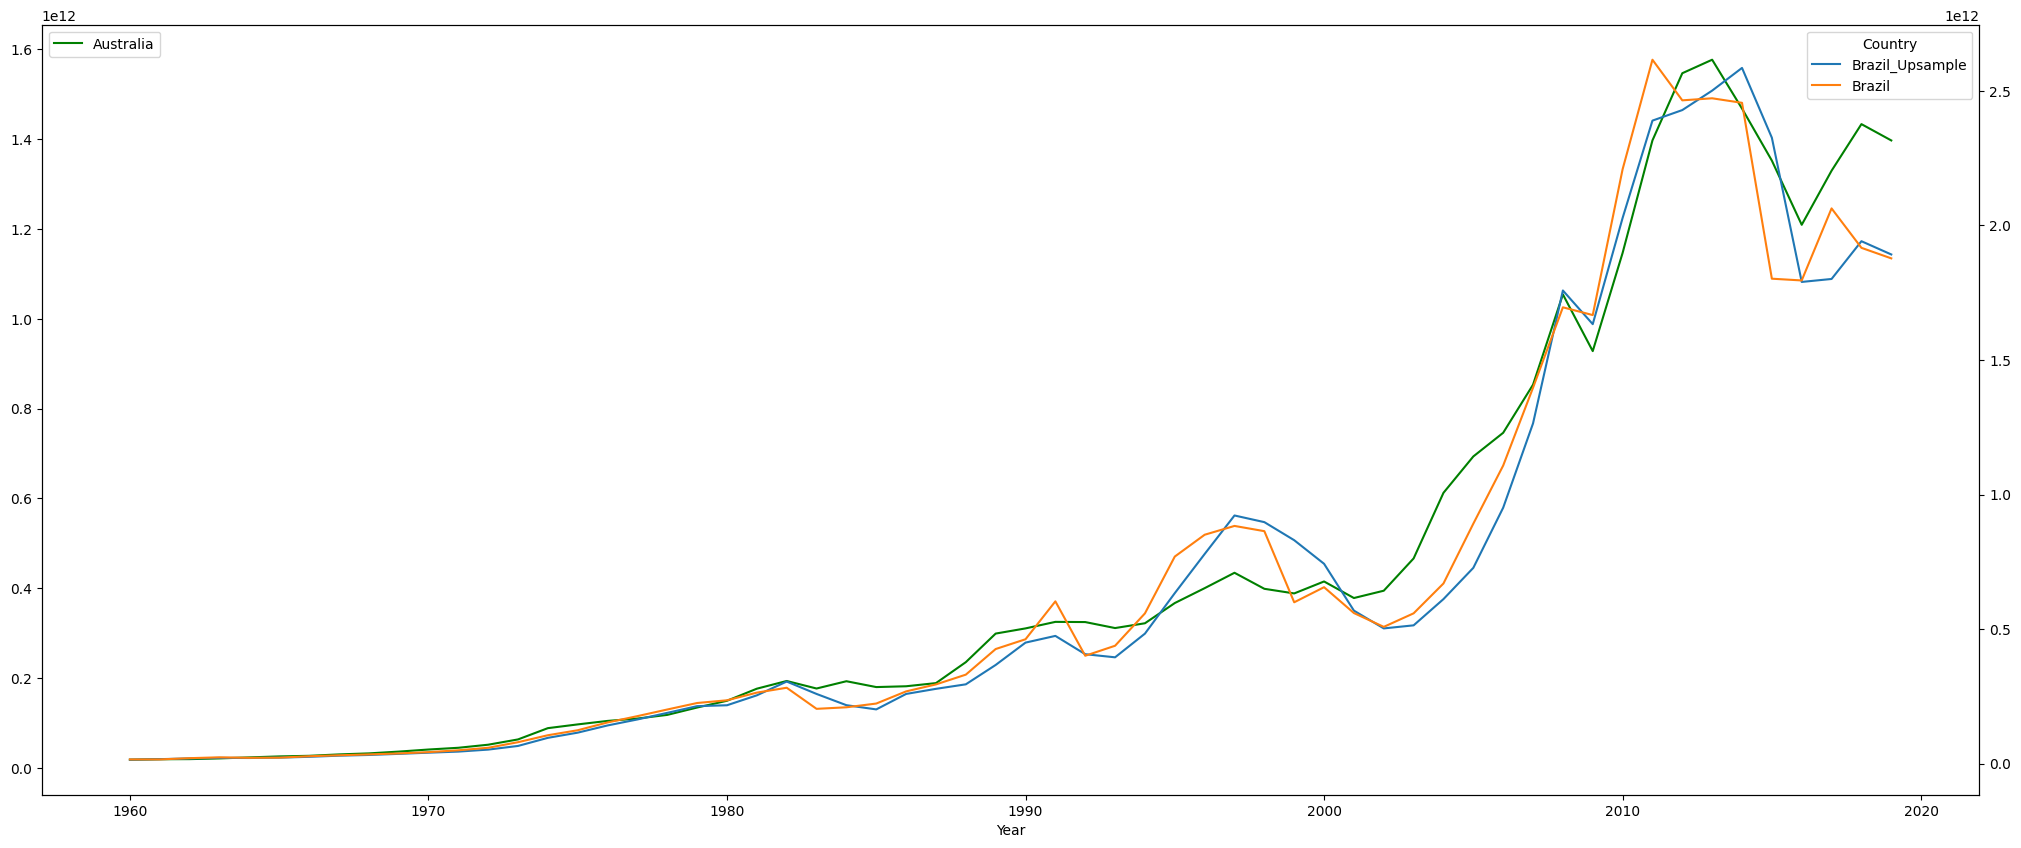

In [6]:
data[["Australia"]].plot(color = "green")
plt.legend(loc='upper left')
ax = plt.gca().twinx()
data[["Brazil_Upsample", "Brazil"]].plot(ax = ax);
plt.show();

#### Consistency <a name='Consistency'></a>

We check the `benchmark` package is consistent with the `statsmodels` package.

In [7]:
high_frequency_data = data["Australia"].values
low_frequency_data = data["Brazil_Downsample"].dropna().values

estimator = Estimator()
estimator.fit(high_frequency_data, low_frequency_data)

Estimator(linear_constraint=array([0.5, 0.5]), quadratic_constraint_weight=0)

Having called the `fit` method, we can call the `predict` method to determine the up-sampled data. 

In [7]:
interpolant = estimator.predict()
data["Brazil_Upsample"].values - interpolant

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

Note that the predictions of the `benchmark` library match the predictions of the `statsmodels` library.

#### Evaluation <a name='Evaluation'></a>

We want to assess the predictions with metrics.

In [8]:
estimator.score()

1.0

We can calculate the score. Here the score is the correlation between the low frequency data and the up-sampled data under Canonical Correlation Analysis.

In [9]:
np.corrcoef(interpolant, data["Brazil"].values)[0,1]

0.9909516029131233

Alternatively, we can compute the correlation between the observed Brazilian GDP and the up-sampled data. Usually, we do not have access to the ground truth data. 

In [10]:
estimator.transform()

array([-1.116 , -1.1122, -1.1018, -1.092 , -1.0774, -1.055 , -1.022 ,
       -0.928 , -0.888 , -0.8459, -0.7572, -0.6702, -0.6692, -0.6857,
       -0.5096, -0.3449, -0.3259, -0.2956, -0.0987, -0.1308, -0.1052,
       -0.0895,  0.4848,  0.85  ,  1.5046,  1.9857,  2.8886,  2.5902,
        2.0662,  2.5507])

We choose Australia because Brazil and Australia have some commonalities. For example, both have a dependence on commodities. The `transform` method projects the high frequency data to low frequency data with Canonical Correlation Analysis.  

In [11]:
projection = estimator.projection
projection

array([0.9494, 0.3139])

The projection is accessible with the `projection` attribute.

#### Objective <a name='Objective'></a>

A subject matter expert can help us to determine the high-frequency dataset. If we lack a high frequency dataset, then we can use a constant value like 1.

In [12]:
high_frequency_data = np.ones(data["Australia"].shape)
low_frequency_data = data["Brazil_Downsample"].dropna().values

estimator = Estimator()
estimator.fit(high_frequency_data, low_frequency_data)

Estimator(linear_constraint=array([0.5, 0.5]), quadratic_constraint_weight=0)

If the high-frequency dataset has the constant value 1, then the objective function requires small consecutive differences of the up-sampled dataset. Again the linear constraint requires pairs of values to match the low-frequency dataset on average.

In [13]:
interpolant_constant = estimator.predict()

Since Australian GDP and Brazilian GDP have comparable trends, we do not observe much difference in the up-sampled dataset.

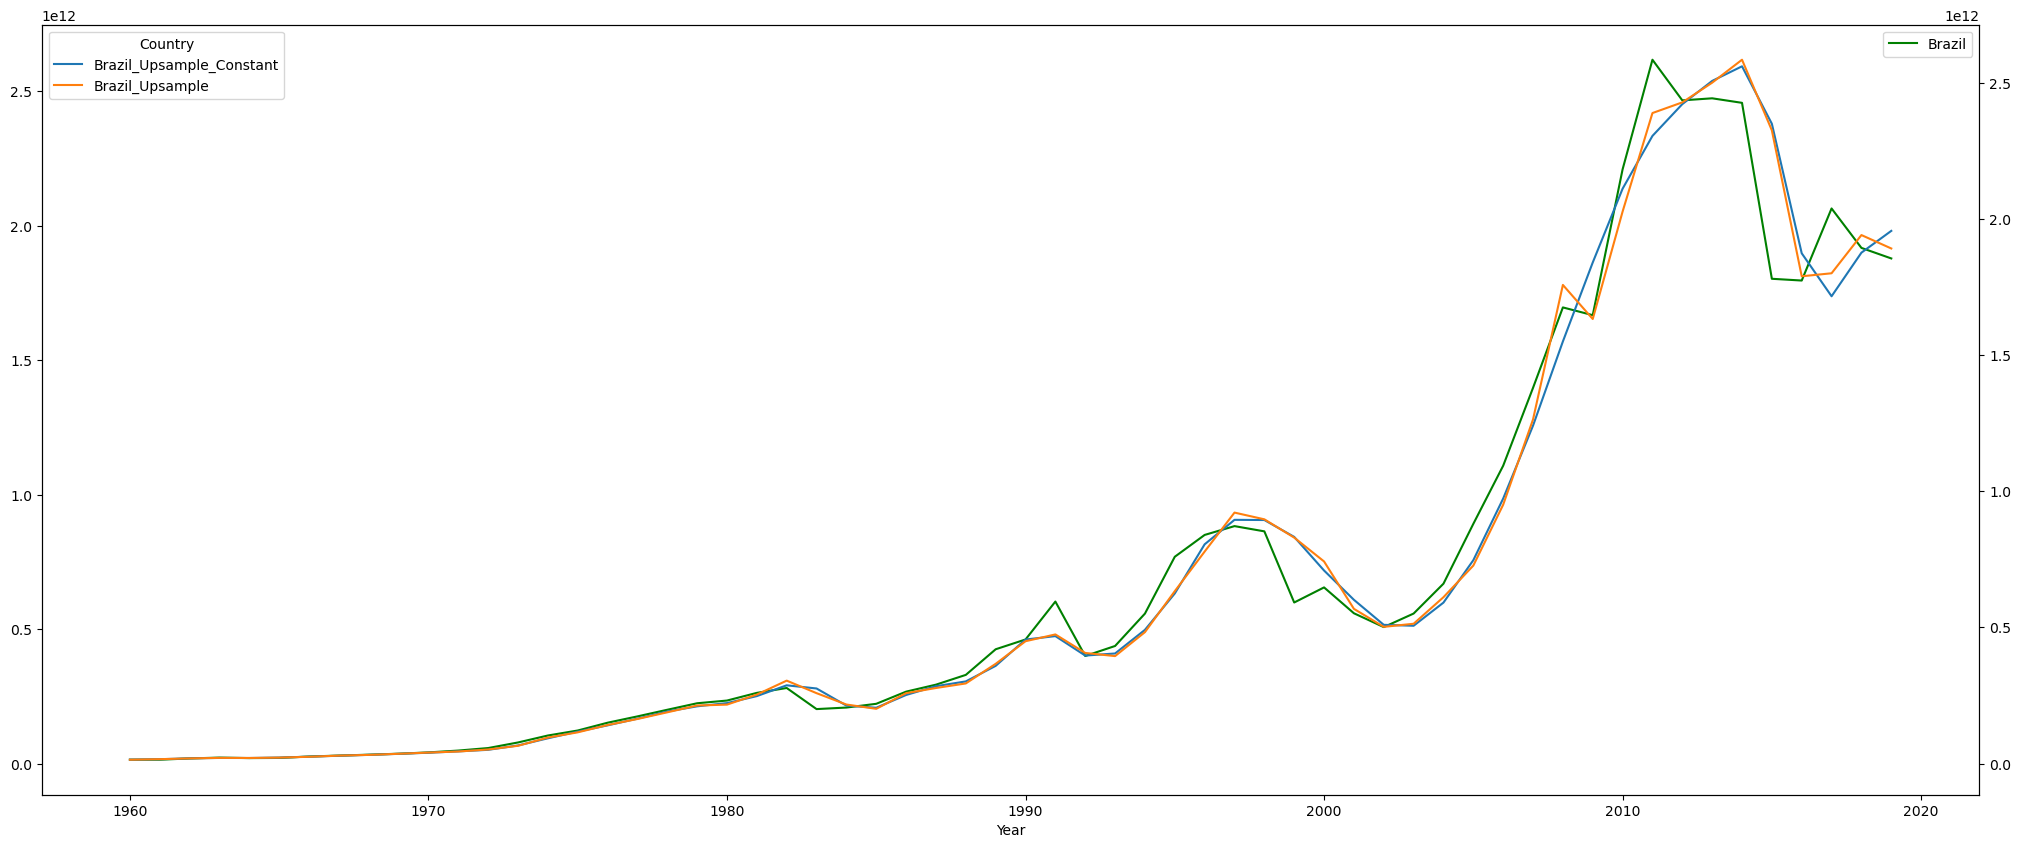

In [14]:
data["Brazil_Upsample_Constant"] = interpolant_constant
data[["Brazil"]].plot(color = "green")
plt.legend()
ax = plt.gca().twinx()
data[["Brazil_Upsample_Constant", "Brazil_Upsample"]].plot(ax = ax);
plt.show();

#### Linear Constraints <a name='Linear'></a>

Unlike the `statsmodels` package, the `benchmark` package allows us to change the linear constraints.

In [15]:
high_frequency_data = data["Australia"].values
low_frequency_data = data["Brazil_Downsample"].dropna().values
linear_constraint = [1,0]

estimator = Estimator(linear_constraint=linear_constraint)
estimator.fit(high_frequency_data, low_frequency_data)

Estimator(linear_constraint=array([1, 0]), quadratic_constraint_weight=0)

Here we use the linear constraint `[1,0]` to signify that values in the up-sampled data need to match values in the low frequency data. We peg one of two missing values to the obseved data.

In [16]:
interpolant_pegged = estimator.predict()
interpolant_pegged[::2] - data["Brazil"].values[::2]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

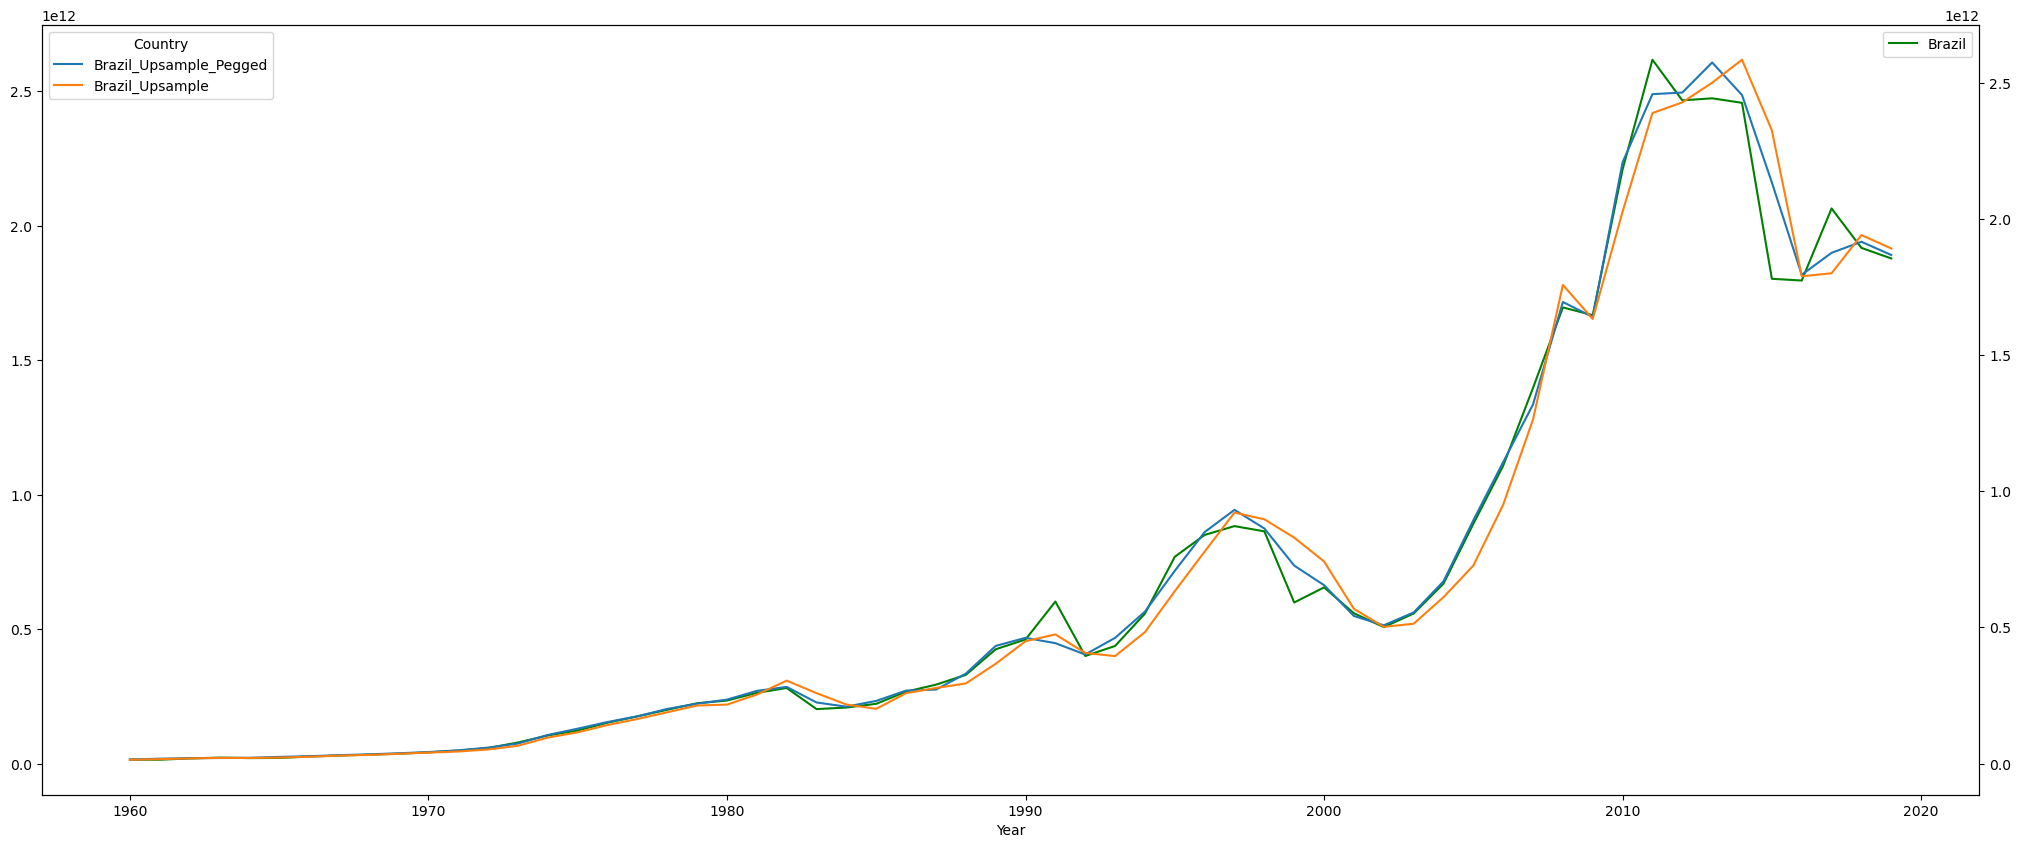

In [17]:
data["Brazil_Upsample_Pegged"] = interpolant_pegged
data[["Brazil"]].plot(color = "green")
plt.legend()
ax = plt.gca().twinx()
data[["Brazil_Upsample_Pegged", "Brazil_Upsample"]].plot(ax = ax);
plt.show();

#### Quadratic Constraint <a name='Quadratic'></a> 

Unlike the `statsmodels` package, the `benchmark` package allows us to add a quadratic constraints.

In [18]:
data["Annotations"] = np.NaN

random_number_generator = np.random.RandomState(seed = 17)
size_annotation = len(data["Brazil"][3::4])

data["Annotations"][3::4] = data["Brazil"][3::4] + random_number_generator.randn(size_annotation) * 1e9

Here we simulate the guesses of a subject matter expert. Every fourth year, we guess a value for the missing Brazilian GDP. Note that the guesses are inexact.

In [19]:
high_frequency_data = data["Australia"].values
low_frequency_data = data["Brazil_Downsample"].dropna().values
annotation_data = data["Annotations"].values
quadratic_constraint_weight = 0

estimator = Estimator()
estimator.fit(high_frequency_data, low_frequency_data)

Estimator(linear_constraint=array([0.5, 0.5]), quadratic_constraint_weight=0)

If we set the attribute `quadratic_constraint_weight` to 0, then we remove the quadratic constraint. Note the consistency with the preceding predictions.

In [20]:
interpolant_annotations = estimator.predict()
data["Brazil_Upsample"].values - interpolant_annotations

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

However, if we set the attribute `quadratic_constraint_weight` to 1, then we get different predictions.

In [21]:
quadratic_constraint_weight = 1

estimator =  Estimator(quadratic_constraint_weight=quadratic_constraint_weight)
estimator.fit(high_frequency_data, low_frequency_data, annotation_data)

interpolant_annotations = estimator.predict()

We learn that the guesses did not improve the predictions. 

In [22]:
mae = np.average(np.abs(data["Brazil"].values - interpolant))
mae_annotation = np.average(np.abs(data["Brazil"].values - interpolant_annotations))

print(f"Mean Absolute Error without Quadratic Constraint {mae}")
print(f"Mean Absolute Error with Quadratic Constraint {mae_annotation}")

Mean Absolute Error without Quadratic Constraint 55456158173.50534
Mean Absolute Error with Quadratic Constraint 60912165989.2041


However the guesses were inexact. If we use more exact guesses, then we can improve the predictions.

In [23]:
annotation_data = data["Brazil"].copy()
annotation_data[::2] = np.NaN

estimator =  Estimator(quadratic_constraint_weight=quadratic_constraint_weight)
estimator.fit(high_frequency_data, low_frequency_data, annotation_data)

interpolant_annotations_exact = estimator.predict()

Note the decrease in Mean Absolute Error.

In [24]:
mae_annotation_exact = np.average(np.abs(data["Brazil"].values - interpolant_annotations_exact))

print(f"Mean Absolute Error without Quadratic Constraint {mae}")
print(f"Mean Absolute Error with Quadratic Constraint {mae_annotation_exact}")

Mean Absolute Error without Quadratic Constraint 55456158173.50534
Mean Absolute Error with Quadratic Constraint 51595560844.11667


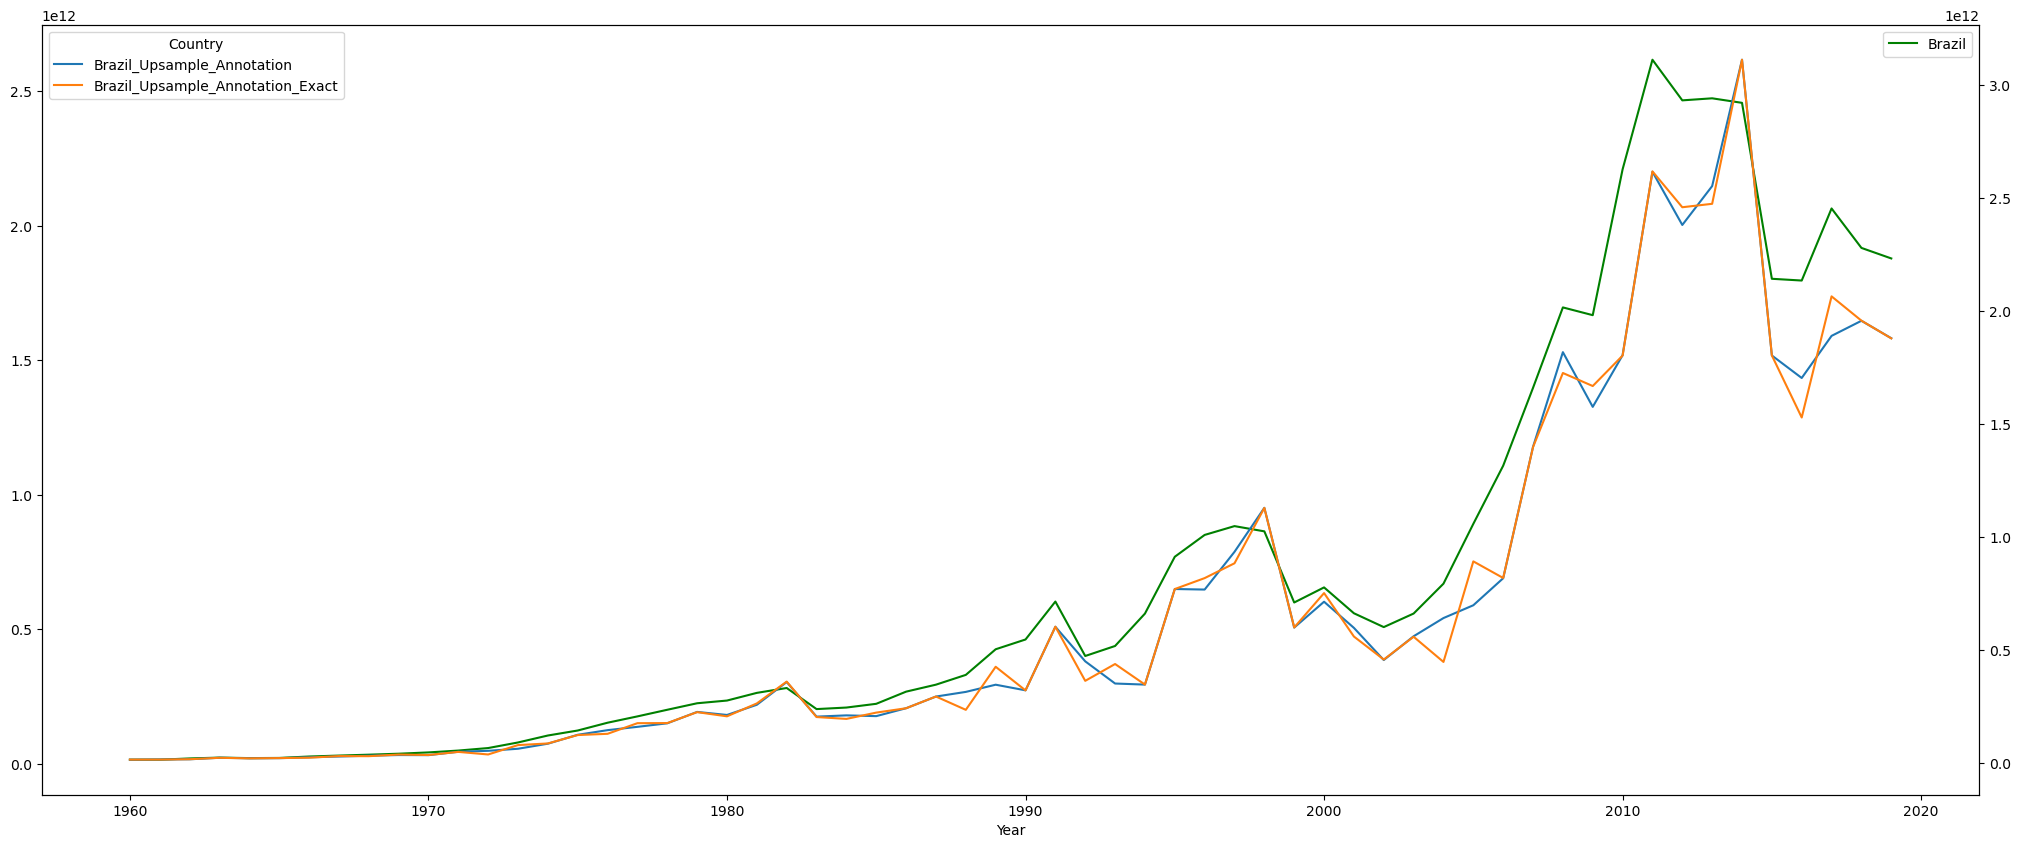

In [25]:
data["Brazil_Upsample_Annotation"] = interpolant_annotations
data["Brazil_Upsample_Annotation_Exact"] = interpolant_annotations_exact

data[["Brazil"]].plot(color = "green")
plt.legend()
ax = plt.gca().twinx()
data[["Brazil_Upsample_Annotation", "Brazil_Upsample_Annotation_Exact"]].plot(ax = ax);
plt.show();

#### Solvers <a name='Solvers'></a>

The `benchmark` library allows us to change the constraints for the optimization problem. Additionally, the `benchmark` library allows us to change the objective. We can supply an exact or approximate solver. 

##### Exact Solvers

The default objective is a multiplicative objective studying the difference of consecutive ratios between the high frequency data and the up-sampled data. We could change to an additive objective. Here we have the difference of consecutive differences between the high frequency data and the up-sampled data.

In [ ]:
def solver(high_frequency_data: ArrayLike, 
           low_frequency_data: ArrayLike, 
           annotation_data: ArrayLike, 
           linear_constraint: ArrayLike, 
           quadratic_constraint_weight: Union[float,int]) -> ArrayLike:

    t = len(low_frequency_data)
    T = len(high_frequency_data)
    k = T // t

    constraints_matrix = np.kron(np.eye(t), linear_constraint.reshape(-1,1))

    cost_derivative_matrix = np.eye(T)
    diag_idx0, diag_idx1 = np.diag_indices(T)
    cost_derivative_matrix[diag_idx0[1:-1], diag_idx1[1:-1]] += 1
    cost_derivative_matrix[diag_idx0[:-1]+1, diag_idx1[:-1]] = -1
    cost_derivative_matrix[diag_idx0[:-1], diag_idx1[:-1]+1] = -1

    cost_matrix = 2 * cost_derivative_matrix

    annotation_matrix = np.zeros(annotation_data.shape)
    annotation_matrix[~np.isnan(annotation_data)] = 1
    annotation_matrix = np.diag(annotation_matrix)
    annotation_matrix = 2 * quadratic_constraint_weight * annotation_matrix

    matrix = np.zeros((T+t, T+t))  
    matrix[:T,:T] = cost_matrix + annotation_matrix
    matrix[:T,T:] = constraints_matrix
    matrix[T:,:T] = constraints_matrix.T

    values = np.zeros((t+T,1)) 
    values[:T] = (np.hstack([0, np.diff(high_frequency_data)]) - np.hstack([np.diff(high_frequency_data), 0])).reshape(-1,1)
    values[:T] += 2 * quadratic_constraint_weight * np.nan_to_num(annotation_data).reshape(-1,1)
    values[-t:] = low_frequency_data.reshape(-1,1) 

    X = np.linalg.solve(matrix, values)
    X = X[:-t] 

    return X.squeeze()

We can solve for the solutions of optimization problem. So we have implemented an exact solver.

In [80]:
high_frequency_data = data["Australia"].values
low_frequency_data = data["Brazil_Downsample"].dropna().values

estimator = Estimator(solver=solver)
estimator.fit(high_frequency_data, low_frequency_data)

interpolant_additive = estimator.predict()

Note that the multiplicative objective gives more accurate predictions than the additive objective. 

In [81]:
mae_additive = np.average(np.abs(data["Brazil"].values - interpolant_additive))

print(f"Mean Absolute Error without Quadratic Constraint {mae}")
print(f"Mean Absolute Error with Quadratic Constraint {mae_additive}")

Mean Absolute Error without Quadratic Constraint 55456158173.50534
Mean Absolute Error with Quadratic Constraint 58648786695.14173


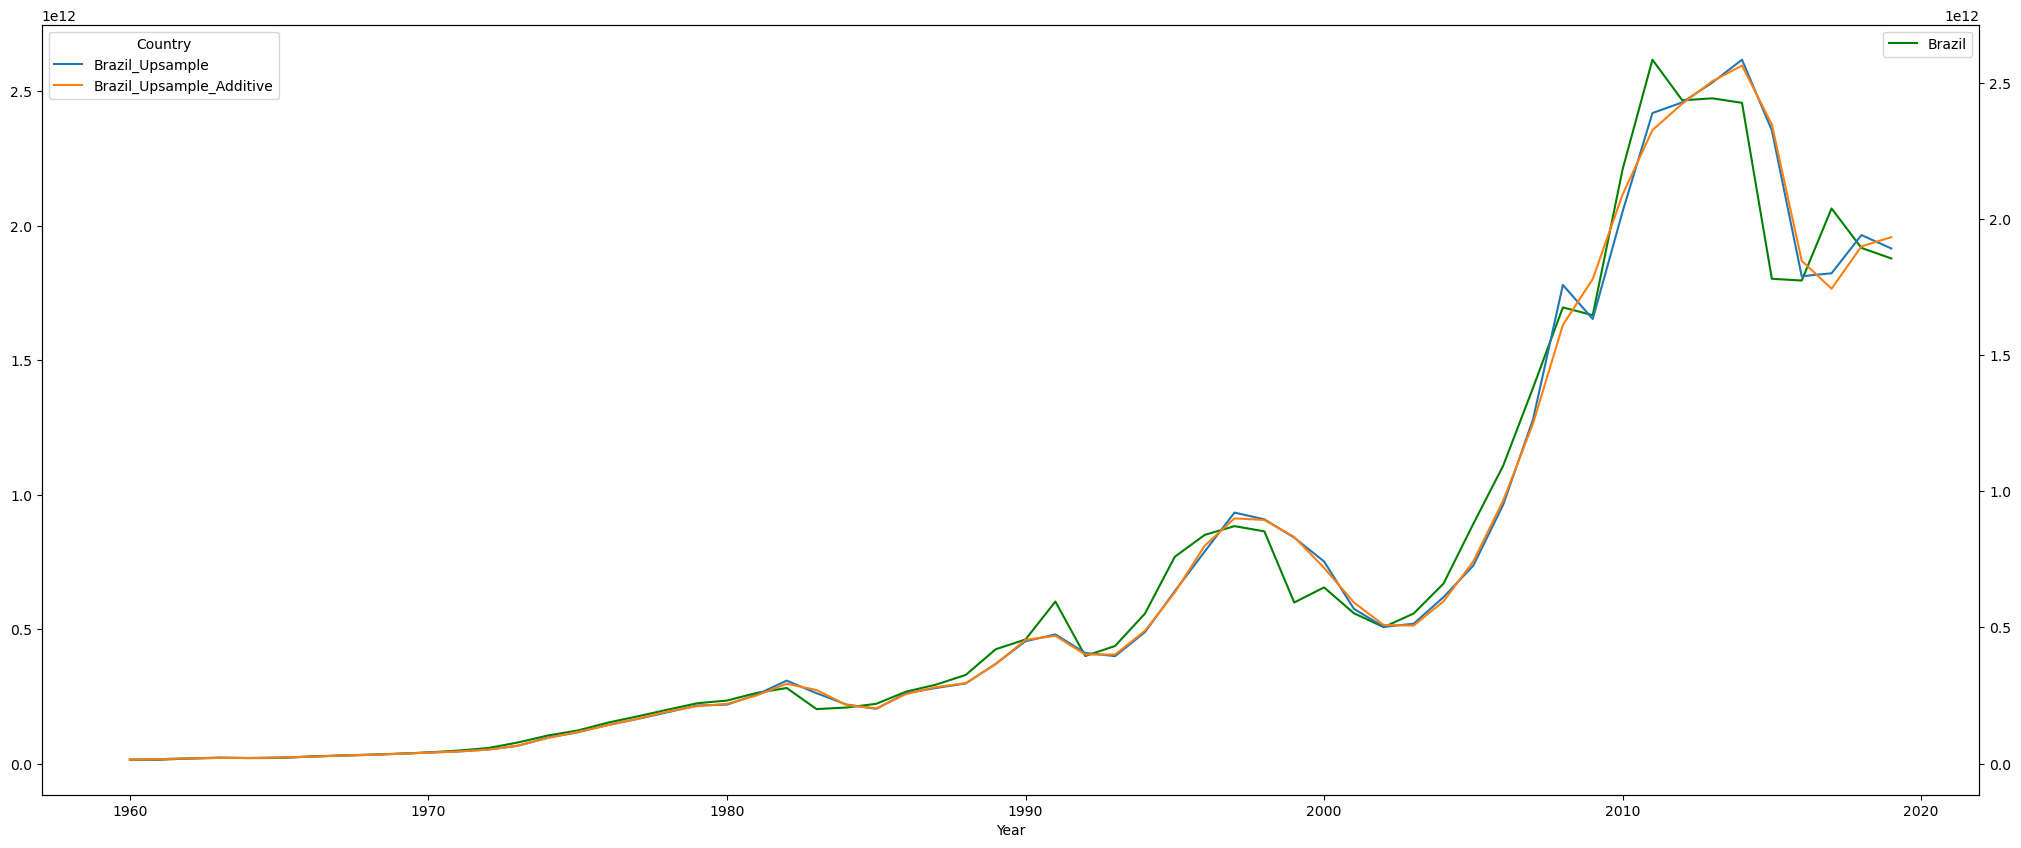

In [82]:
data["Brazil_Upsample_Additive"] = interpolant_additive
data[["Brazil"]].plot(color = "green")
plt.legend()
ax = plt.gca().twinx()
data[["Brazil_Upsample", "Brazil_Upsample_Additive"]].plot(ax = ax);
plt.show();

##### Approximate Solvers 

The [Hodrick-Prescott filter](https://en.wikipedia.org/wiki/Hodrick%E2%80%93Prescott_filter) decomposes a time-series into a cyclical component and a trend component. The filter removes curvature from the time-series to determine the trend component. 

We can recover the Hodrick-Prescott filter through a particular combination of objective and constraints. We need to take a linear constraint consisting of zeroes. If we take the linear constraint to consist of zeroes, then we remove the linear constraint meaning we omit the benchmark from the optimization problem. 

In [31]:
# australia_cycle, australia_trend = statsmodels.tsa.filters.hp_filter.hpfilter(data["Australia"].values, lamb = 1)
australia_cycle, australia_trend = sm.tsa.filters.hpfilter(data["Australia"].values, lamb = 1)

In [32]:
def solver(high_frequency_data: ArrayLike, 
           low_frequency_data: ArrayLike, 
           annotation_data: ArrayLike, 
           linear_constraint: ArrayLike, 
           quadratic_constraint_weight: Union[float,int]) -> ArrayLike:

    def _objective(X,Y = annotation_data):
        return quadratic_constraint_weight * np.sum((X-Y)**2) + np.sum(np.diff(X, 2)**2)
    
    output = scipy.optimize.minimize(_objective, 
                                     method = "Powell", 
                                     x0 = high_frequency_data, 
                                     args=(annotation_data))
    
    return output.x

In [33]:
high_frequency_data = np.ones(data["Australia"].shape[0])
low_frequency_data = data["Brazil_Downsample"].dropna().values
annotation_data = data["Australia"].values
quadratic_constraint_weight = 1

estimator = Estimator(quadratic_constraint_weight = quadratic_constraint_weight, solver = solver)
estimator.fit(high_frequency_data, low_frequency_data, annotation_data = annotation_data)

Estimator(linear_constraint=array([0.5, 0.5]), quadratic_constraint_weight=1,
          solver=<function solver at 0x000002A29D372048>)

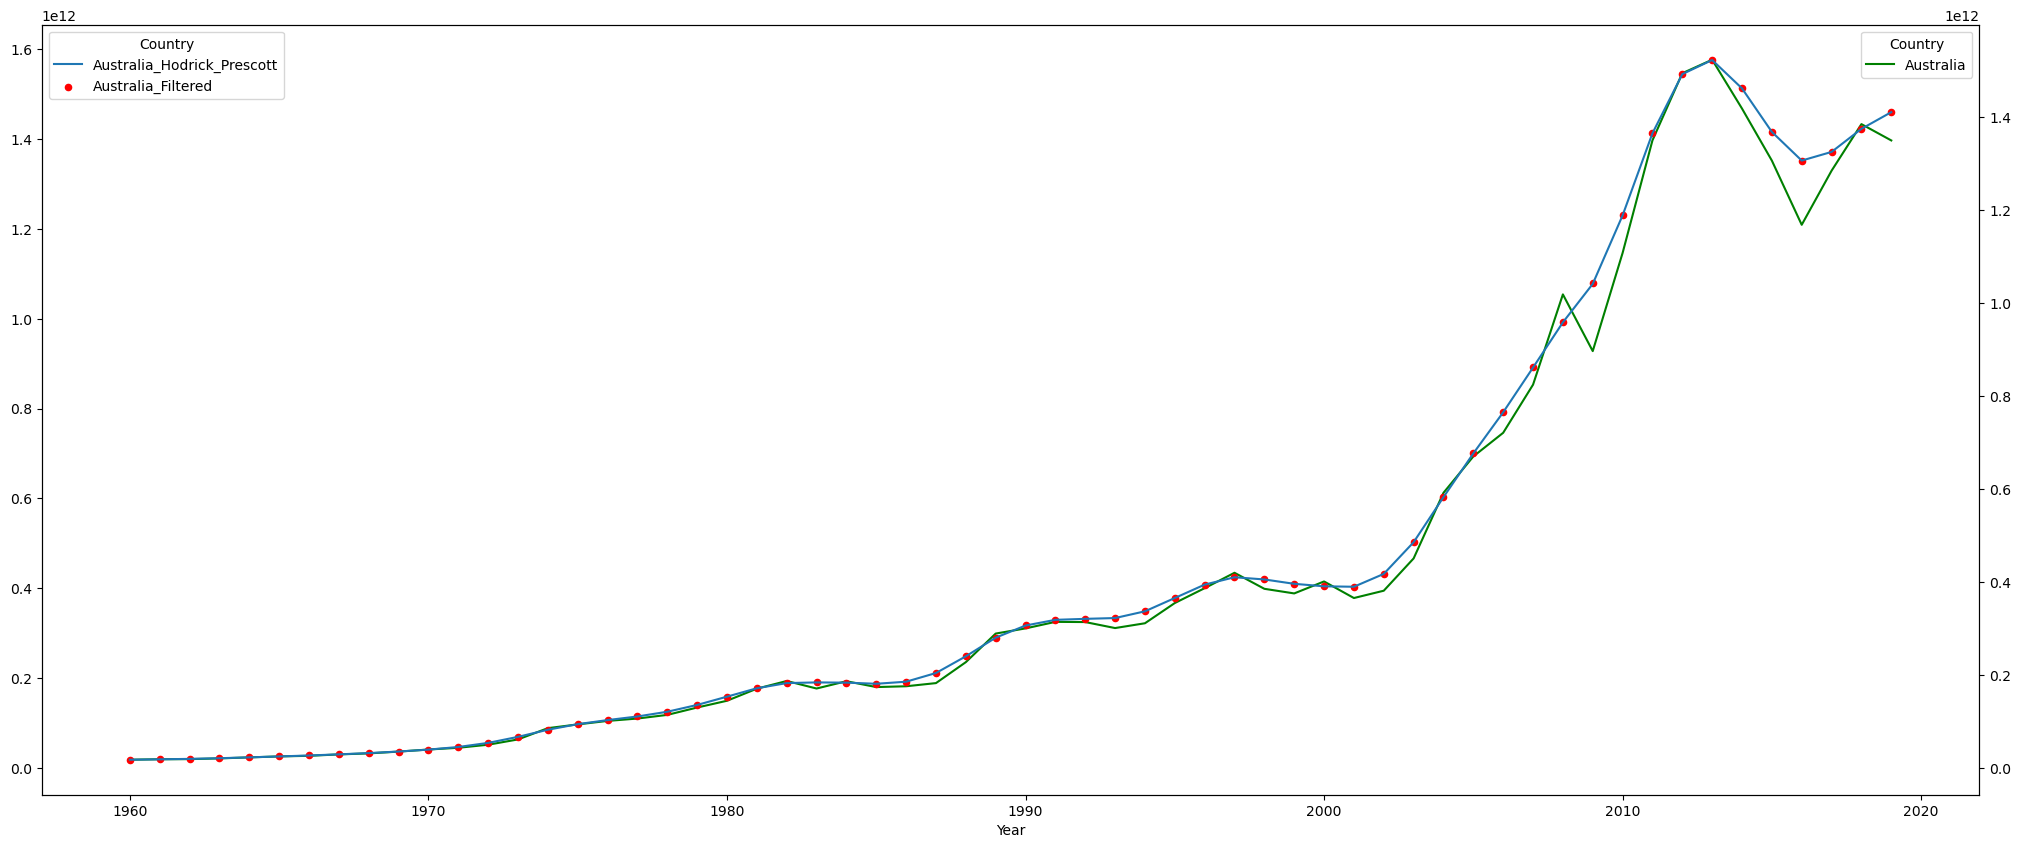

In [34]:
data["Australia_Filtered"] = estimator.predict()
data["Australia_Hodrick_Prescott"] = australia_trend

data[["Australia"]].plot(color = "green");
# plt.legend(loc = "upper left")
ax = plt.gca().twinx()
data[["Australia_Hodrick_Prescott"]].reset_index().plot.scatter(x = "Year", y = "Australia_Hodrick_Prescott", ax = ax, c = "r", label = "Australia_Hodrick_Prescott");
data[["Australia_Filtered"]].plot(ax = ax);
plt.ylabel("")
plt.show();

Note that we have a match between the up-sampled data and the Hodrick-Prescott filter implemented in the `statsmodels` library.

#### Tuning <a name='Tuning'></a>

The ability to adjust the linear constraint in the `benchmark` library allows us to programmatically determine the linear constraint. 

- Sum 
- Average
- First Value 
- Last Value 

A subject matter expert might suggest different linear constraints. However we can treat the linear constraint like a hyperparameter. Therefore we can employ hyperparameter search like grid search. Since the `benchmark` library adheres to the scikit-learn API, we can leverage the scikit-learn package to tune hyperparameters.  

In [30]:
high_frequency_data = data["Australia"].values
low_frequency_data = data["Brazil_Downsample"].dropna().values

frequency = len(high_frequency_data) // len(low_frequency_data)
high_frequency_data_reshaped = high_frequency_data.reshape(-1, frequency)

In [31]:
x, y = np.meshgrid(np.arange(0,5,1), np.arange(0,5,1))
x, y = x.flatten(), y.flatten()
linear_constraint_params = [np.asarray(pair) for pair in zip(x,y)][1:]

In [32]:
tunable_parameters = {"linear_constraint": linear_constraint_params}
predictor = GridSearchCV(Estimator(), tunable_parameters, cv = 2)

In [33]:
predictor.fit(high_frequency_data_reshaped, low_frequency_data)

GridSearchCV(cv=2, estimator=Estimator(),
             param_grid={'linear_constraint': [array([1, 0]), array([2, 0]),
                                               array([3, 0]), array([4, 0]),
                                               array([0, 1]), array([1, 1]),
                                               array([2, 1]), array([3, 1]),
                                               array([4, 1]), array([0, 2]),
                                               array([1, 2]), array([2, 2]),
                                               array([3, 2]), array([4, 2]),
                                               array([0, 3]), array([1, 3]),
                                               array([2, 3]), array([3, 3]),
                                               array([4, 3]), array([0, 4]),
                                               array([1, 4]), array([2, 4]),
                                               array([3, 4]), array([4, 4])]})

We learn that the First Value is the optimal linear constraint among the options.

In [34]:
predictor.best_params_

{'linear_constraint': array([1, 0])}